In [1]:
import math
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from pandas import json_normalize
import yaml
from yaml import CSafeLoader as Loader

sns.set_context("paper", font_scale=3)

# LOG_DIR = os.path.expanduser("~/jean-zay/emergent_communication/lightning_logs_final/")
LOG_DIR = os.path.expanduser("~/PhD/emergent_communication/emergent_communication/lightning_logs_final/")
# LOG_DIR = os.path.expanduser("~/PhD/emergent_communication/emergent_communication/lightning_logs_cluster/")


REFERENCE_METRIC = "val_acc"

In [2]:
import torch

# Remove superfluous NaN cells
def compress(values):
    for val in values:
        if val is not None and not np.isnan(val):
            return val
        
results_df = []
for run_dir in tqdm(os.listdir(LOG_DIR)):
    run_path = os.path.join(LOG_DIR, run_dir, "checkpoints/")

    results = glob.glob(run_path+f"*{REFERENCE_METRIC}=*.pickle")
    if len(results) < 1:
        run_path = os.path.join(LOG_DIR, run_dir)
        results = glob.glob(run_path+f"/*.pickle")
        if len(results) >= 1:
            print(f"considering pre-final results for run {run_dir[8:]}")
            if run_dir[8:] == "31521":
                print("gre")

    for result in results:
        try:
            print(result)
            data = pd.read_pickle(result)
        except Exception as e:
            print(result)
            print(e)
            continue
            
        if isinstance(data, list):
            df = pd.DataFrame.from_records(data)
            df = df.groupby(["dir_name", "epoch"]).aggregate(compress)
        else:
            if "receiver_aux_loss" in data.keys():
                data["receiver_auxiliary_loss"] = data["receiver_aux_loss"]
                del data["receiver_aux_loss"]
            df = pd.DataFrame.from_records([{k: v.item() if torch.is_tensor(v) else v for k, v in data.items()}])
        
        df["dir_name"] = run_dir
        if "epoch" in result:
            df["epoch"] = int(result.split("epoch=")[1].split("-")[0])
        results_df.append(df)


results_df = pd.concat(results_df, ignore_index=True)

results_df.reset_index(inplace=True)
results_df

  2%|▏         | 7/354 [00:00<00:06, 55.80it/s]

considering pre-final results for run 42294
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_42294/results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_39/checkpoints/epoch=39-val_acc=0.67_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_40064/checkpoints/epoch=299-val_acc=0.90_results.pickle
considering pre-final results for run 42214
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_42214/results.pickle
considering pre-final results for run 47547
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_47547/results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_37437/checkpoints/epoch=179-val_acc=0.79_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_2148

  4%|▎         | 13/354 [00:00<00:06, 56.01it/s]

/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_266/checkpoints/epoch=49-val_acc=0.92_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_43940/checkpoints/epoch=279-val_acc=0.93_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_41768/checkpoints/epoch=3279-val_acc=0.85_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_37109/checkpoints/epoch=4399-val_acc=0.61_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_22451/checkpoints/epoch=3399-val_acc=0.74_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_59123/checkpoints/epoch=109-val_acc=0.99_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_22558/checkpoints/epoch=39-

  7%|▋         | 25/354 [00:00<00:07, 46.23it/s]

/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_41781/checkpoints/epoch=1579-val_acc=0.61_results.pickle
considering pre-final results for run 21573
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_21573/results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_40740/checkpoints/epoch=3699-val_acc=0.88_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_40705/checkpoints/epoch=3419-val_acc=0.63_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_32/checkpoints/epoch=69-val_acc=0.94_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_31640/checkpoints/epoch=999-val_acc=0.96_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_37436/checkpoints/e

 10%|█         | 37/354 [00:00<00:06, 50.81it/s]

considering pre-final results for run 21570
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_21570/results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_36568/checkpoints/epoch=339-val_acc=0.96_results.pickle
considering pre-final results for run 42201
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_42201/results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_43/checkpoints/epoch=19-val_acc=0.99_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_43931/checkpoints/epoch=79-val_acc=0.93_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_56022/checkpoints/epoch=2499-val_acc=0.90_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_37213/checkpo

 14%|█▎        | 48/354 [00:01<00:07, 42.95it/s]

/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_36570/checkpoints/epoch=399-val_acc=0.66_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_15/checkpoints/epoch=49-val_acc=0.66_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_259/checkpoints/epoch=49-val_acc=0.97_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_44319/checkpoints/epoch=759-val_acc=0.70_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_36096/checkpoints/epoch=1959-val_acc=0.43_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_40702/checkpoints/epoch=2399-val_acc=0.60_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_40067/checkpoints/epoch=199-val_

 15%|█▍        | 53/354 [00:01<00:06, 44.36it/s]

/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_46509/checkpoints/epoch=5439-val_acc=0.92_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_43942/checkpoints/epoch=119-val_acc=0.99_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_46036/checkpoints/epoch=779-val_acc=0.96_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_56016/checkpoints/epoch=2259-val_acc=0.90_results.pickle
considering pre-final results for run 42204
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_42204/results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_36084/checkpoints/epoch=1239-val_acc=0.87_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_36095/checkpoin

 18%|█▊        | 65/354 [00:01<00:06, 47.41it/s]

/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_37/checkpoints/epoch=29-val_acc=0.99_results.pickle
considering pre-final results for run 45838
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_45838/results.pickle
considering pre-final results for run 42305
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_42305/results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_40054/checkpoints/epoch=119-val_acc=0.78_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_48642/checkpoints/epoch=3339-val_acc=0.89_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_37211/checkpoints/epoch=2799-val_acc=0.89_results.pickle
considering pre-final results for run 42299
/home/mitja/PhD/emergent_communication/emergent_communicat

 21%|██        | 75/354 [00:01<00:05, 46.68it/s]

/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_48589/checkpoints/epoch=79-val_acc=0.58_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_46039/checkpoints/epoch=2859-val_acc=0.97_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_37108/checkpoints/epoch=2739-val_acc=0.83_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_56021/checkpoints/epoch=2459-val_acc=0.89_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_37432/checkpoints/epoch=159-val_acc=0.96_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_31550/checkpoints/epoch=139-val_acc=0.99_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_44147/checkpoints/epoch=1

 24%|██▍       | 85/354 [00:01<00:06, 39.87it/s]

/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_46193/checkpoints/epoch=2279-val_acc=0.97_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_23103/checkpoints/epoch=399-val_acc=0.83_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_40057/checkpoints/epoch=359-val_acc=0.86_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_40055/checkpoints/epoch=459-val_acc=0.86_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_40058/checkpoints/epoch=39-val_acc=0.76_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_36569/checkpoints/epoch=279-val_acc=0.69_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_40069/checkpoints/epoch=239

 27%|██▋       | 96/354 [00:02<00:05, 45.22it/s]

/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_41771/checkpoints/epoch=2999-val_acc=0.84_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_40703/checkpoints/epoch=2759-val_acc=0.63_results.pickle
considering pre-final results for run 21795
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_21795/results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_39926/checkpoints/epoch=299-val_acc=0.91_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_50910/checkpoints/epoch=179-val_acc=0.99_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_43935/checkpoints/epoch=239-val_acc=0.99_results.pickle
considering pre-final results for run 31649
/home/mitja/PhD/emergent_communication/emergent_communication/l

 31%|███       | 110/354 [00:02<00:04, 50.21it/s]

/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_36565/checkpoints/epoch=319-val_acc=0.99_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_41834/checkpoints/epoch=479-val_acc=0.89_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_44307/checkpoints/epoch=579-val_acc=0.74_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_36011/checkpoints/epoch=159-val_acc=0.70_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_46209/checkpoints/epoch=2979-val_acc=0.92_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_22603/checkpoints/epoch=3799-val_acc=0.78_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_36012/checkpoints/epoch=3

 33%|███▎      | 116/354 [00:02<00:04, 49.19it/s]

/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_45752/checkpoints/epoch=4319-val_acc=0.96_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_36566/checkpoints/epoch=239-val_acc=0.82_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_36010/checkpoints/epoch=239-val_acc=0.97_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_13/checkpoints/epoch=89-val_acc=0.96_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_36088/checkpoints/epoch=1339-val_acc=0.83_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_41/checkpoints/epoch=59-val_acc=0.99_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_36008/checkpoints/epoch=139-val_a

 36%|███▌      | 126/354 [00:02<00:04, 46.20it/s]

/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_36/checkpoints/epoch=39-val_acc=0.99_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_22275/checkpoints/epoch=2739-val_acc=0.85_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_48595/checkpoints/epoch=339-val_acc=0.58_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_56003/checkpoints/epoch=1839-val_acc=0.94_results.pickle
considering pre-final results for run 22255
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_22255/results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_45814/checkpoints/epoch=2279-val_acc=0.97_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_47/checkpoints/epoc

 39%|███▊      | 137/354 [00:02<00:04, 46.52it/s]

/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_8/checkpoints/epoch=89-val_acc=0.92_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_31641/checkpoints/epoch=759-val_acc=0.99_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_40742/checkpoints/epoch=3059-val_acc=0.87_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_39912/checkpoints/epoch=539-val_acc=0.96_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_265/checkpoints/epoch=79-val_acc=0.98_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_44299/checkpoints/epoch=1899-val_acc=0.70_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_261/checkpoints/epoch=09-val_acc=

 40%|████      | 142/354 [00:03<00:04, 44.90it/s]

/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_22559/checkpoints/epoch=399-val_acc=0.98_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_37110/checkpoints/epoch=3539-val_acc=0.42_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_39908/checkpoints/epoch=339-val_acc=0.99_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_56038/checkpoints/epoch=2339-val_acc=0.50_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_41773/checkpoints/epoch=3659-val_acc=0.85_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_48/checkpoints/epoch=39-val_acc=0.99_results.pickle


 43%|████▎     | 153/354 [00:03<00:05, 38.86it/s]

/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_37214/checkpoints/epoch=1779-val_acc=0.91_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_46208/checkpoints/epoch=5439-val_acc=0.92_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_56015/checkpoints/epoch=3299-val_acc=0.92_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_46196/checkpoints/epoch=2439-val_acc=0.97_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_36560/checkpoints/epoch=39-val_acc=0.99_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_41764/checkpoints/epoch=3399-val_acc=0.89_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_22733/checkpoints/epoch

 47%|████▋     | 167/354 [00:03<00:03, 50.65it/s]

/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_56009/checkpoints/epoch=1919-val_acc=0.94_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_45754/checkpoints/epoch=779-val_acc=0.96_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_36086/checkpoints/epoch=519-val_acc=0.87_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_56001/checkpoints/epoch=1479-val_acc=0.93_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_48587/checkpoints/epoch=319-val_acc=0.58_results.pickle
considering pre-final results for run 31549
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_31549/results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_46212/checkpoint

 49%|████▉     | 175/354 [00:03<00:03, 56.15it/s]

considering pre-final results for run 21572
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_21572/results.pickle
considering pre-final results for run 31527
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_31527/results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_48633/checkpoints/epoch=1479-val_acc=0.89_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_37438/checkpoints/epoch=519-val_acc=0.70_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_19/checkpoints/epoch=49-val_acc=0.70_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_31522/checkpoints/epoch=99-val_acc=0.99_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_36104/checkpo

 53%|█████▎    | 187/354 [00:04<00:03, 49.47it/s]

/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_23127/checkpoints/epoch=19-val_acc=1.00_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_31525/checkpoints/epoch=699-val_acc=1.00_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_40065/checkpoints/epoch=79-val_acc=0.99_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_10/checkpoints/epoch=09-val_acc=0.69_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_38/checkpoints/epoch=49-val_acc=0.91_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_39895/checkpoints/epoch=599-val_acc=0.99_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_12/checkpoints/epoch=89-val_acc=0.98_

 56%|█████▋    | 200/354 [00:04<00:02, 52.15it/s]

/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_6/checkpoints/epoch=29-val_acc=0.99_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_50912/checkpoints/epoch=299-val_acc=0.96_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_46213/checkpoints/epoch=2399-val_acc=0.93_results.pickle
considering pre-final results for run 42218
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_42218/results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_42049/checkpoints/epoch=19-val_acc=1.00_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_56029/checkpoints/epoch=3679-val_acc=0.79_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_50913/checkpoints/epoc

 58%|█████▊    | 207/354 [00:04<00:02, 51.17it/s]

/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_44/checkpoints/epoch=69-val_acc=0.91_results.pickle
considering pre-final results for run 42222
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_42222/results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_39909/checkpoints/epoch=499-val_acc=0.96_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_49/checkpoints/epoch=29-val_acc=0.99_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_254/checkpoints/epoch=69-val_acc=0.90_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_48667/checkpoints/epoch=1259-val_acc=0.37_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_39907/checkpoints/epoch=479-

 62%|██████▏   | 218/354 [00:04<00:02, 46.25it/s]

/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_37223/checkpoints/epoch=859-val_acc=0.46_results.pickle
considering pre-final results for run 31524
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_31524/results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_39890/checkpoints/epoch=19-val_acc=0.99_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_40731/checkpoints/epoch=2919-val_acc=0.75_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_56036/checkpoints/epoch=2479-val_acc=0.51_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_37440/checkpoints/epoch=359-val_acc=0.67_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_40704/checkpoints

 65%|██████▌   | 231/354 [00:04<00:02, 52.65it/s]

/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_34/checkpoints/epoch=79-val_acc=0.97_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_41829/checkpoints/epoch=939-val_acc=0.89_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_36091/checkpoints/epoch=3779-val_acc=0.66_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_36085/checkpoints/epoch=1179-val_acc=0.88_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_7/checkpoints/epoch=69-val_acc=0.98_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_39897/checkpoints/epoch=479-val_acc=0.99_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_9/checkpoints/epoch=59-val_acc=0.8

 69%|██████▊   | 243/354 [00:05<00:02, 48.36it/s]

considering pre-final results for run 31648
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_31648/results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_40066/checkpoints/epoch=299-val_acc=0.95_results.pickle
considering pre-final results for run 22731
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_22731/results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_46035/checkpoints/epoch=3199-val_acc=0.97_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_56014/checkpoints/epoch=1439-val_acc=0.91_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_56028/checkpoints/epoch=2259-val_acc=0.72_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_46511/

 70%|███████   | 248/354 [00:05<00:02, 44.21it/s]

/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_39915/checkpoints/epoch=339-val_acc=0.98_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_48669/checkpoints/epoch=919-val_acc=0.37_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_33/checkpoints/epoch=79-val_acc=0.95_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_22276/checkpoints/epoch=2439-val_acc=0.88_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_40056/checkpoints/epoch=59-val_acc=0.77_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_36564/checkpoints/epoch=499-val_acc=0.96_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_37224/checkpoints/epoch=1519-va

 73%|███████▎  | 258/354 [00:05<00:02, 40.35it/s]

/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_48591/checkpoints/epoch=1539-val_acc=0.58_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_40700/checkpoints/epoch=3539-val_acc=0.64_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_41827/checkpoints/epoch=779-val_acc=0.89_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_28/checkpoints/epoch=69-val_acc=0.78_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_40741/checkpoints/epoch=1539-val_acc=0.80_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_39924/checkpoints/epoch=279-val_acc=0.88_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_36005/checkpoints/epoch=19-v

 75%|███████▌  | 267/354 [00:05<00:02, 38.76it/s]

/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_37225/checkpoints/epoch=1359-val_acc=0.93_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_258/checkpoints/epoch=79-val_acc=0.97_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_31555/checkpoints/epoch=199-val_acc=0.99_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_44315/checkpoints/epoch=979-val_acc=0.69_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_39917/checkpoints/epoch=459-val_acc=0.95_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_37433/checkpoints/epoch=119-val_acc=0.89_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_48648/checkpoints/epoch=2919-

 78%|███████▊  | 276/354 [00:06<00:01, 39.78it/s]

/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_36103/checkpoints/epoch=2839-val_acc=0.87_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_41779/checkpoints/epoch=2059-val_acc=0.65_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_41825/checkpoints/epoch=539-val_acc=0.88_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_36562/checkpoints/epoch=399-val_acc=0.99_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_253/checkpoints/epoch=49-val_acc=0.82_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_256/checkpoints/epoch=39-val_acc=0.56_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_56023/checkpoints/epoch=3679-va

 81%|████████  | 287/354 [00:06<00:01, 43.97it/s]

/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_56010/checkpoints/epoch=1479-val_acc=0.93_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_56017/checkpoints/epoch=3399-val_acc=0.93_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_46512/checkpoints/epoch=3019-val_acc=0.92_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_5/checkpoints/epoch=19-val_acc=1.00_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_48592/checkpoints/epoch=1099-val_acc=0.57_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_40734/checkpoints/epoch=3599-val_acc=0.78_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_48663/checkpoints/epoch=157

 84%|████████▍ | 298/354 [00:06<00:01, 45.32it/s]

/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_44311/checkpoints/epoch=1019-val_acc=0.69_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_251/checkpoints/epoch=39-val_acc=0.70_results.pickle
considering pre-final results for run 42197
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_42197/results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_56034/checkpoints/epoch=1999-val_acc=0.50_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_39914/checkpoints/epoch=539-val_acc=0.95_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_40739/checkpoints/epoch=899-val_acc=0.80_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_21484/checkpoints/e

 88%|████████▊ | 310/354 [00:06<00:00, 47.88it/s]

/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_22453/checkpoints/epoch=1419-val_acc=0.78_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_23123/checkpoints/epoch=39-val_acc=0.99_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_36092/checkpoints/epoch=2339-val_acc=0.64_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_48646/checkpoints/epoch=2499-val_acc=0.83_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_39889/checkpoints/epoch=59-val_acc=0.99_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_23121/checkpoints/epoch=99-val_acc=0.99_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_42046/checkpoints/epoch=19-

 90%|████████▉ | 317/354 [00:06<00:00, 51.46it/s]

/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_23/checkpoints/epoch=19-val_acc=0.78_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_45753/checkpoints/epoch=2979-val_acc=0.97_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_46515/checkpoints/epoch=1319-val_acc=0.92_results.pickle
considering pre-final results for run 31526
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_31526/results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_40698/checkpoints/epoch=2119-val_acc=0.61_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_39922/checkpoints/epoch=259-val_acc=0.88_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_50/checkpoints/epoc

 93%|█████████▎| 328/354 [00:07<00:00, 44.26it/s]

/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_35/checkpoints/epoch=29-val_acc=0.99_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_44320/checkpoints/epoch=1739-val_acc=0.74_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_39925/checkpoints/epoch=259-val_acc=0.96_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_31529/checkpoints/epoch=139-val_acc=0.99_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_44142/checkpoints/epoch=39-val_acc=0.93_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_48666/checkpoints/epoch=1799-val_acc=0.37_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_42023/checkpoints/epoch=19-val

 94%|█████████▍| 333/354 [00:07<00:00, 40.38it/s]

/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_22/checkpoints/epoch=79-val_acc=0.90_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_39896/checkpoints/epoch=99-val_acc=0.99_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_39923/checkpoints/epoch=219-val_acc=0.96_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_264/checkpoints/epoch=19-val_acc=0.99_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_36007/checkpoints/epoch=419-val_acc=0.99_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_42043/checkpoints/epoch=19-val_acc=1.00_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_22452/checkpoints/epoch=2439-val_acc

 97%|█████████▋| 343/354 [00:07<00:00, 38.73it/s]

/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_22605/checkpoints/epoch=1019-val_acc=0.76_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_51/checkpoints/epoch=69-val_acc=0.69_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_48664/checkpoints/epoch=339-val_acc=0.37_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_22737/checkpoints/epoch=1159-val_acc=0.69_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_268/checkpoints/epoch=109-val_acc=0.98_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_40068/checkpoints/epoch=319-val_acc=0.96_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_41762/checkpoints/epoch=2239-va

100%|██████████| 354/354 [00:07<00:00, 45.84it/s]


/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_41776/checkpoints/epoch=3739-val_acc=0.62_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_22602/checkpoints/epoch=2259-val_acc=0.73_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_46210/checkpoints/epoch=3019-val_acc=0.92_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_56032/checkpoints/epoch=3339-val_acc=0.76_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_36561/checkpoints/epoch=59-val_acc=0.99_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_41788/checkpoints/epoch=1319-val_acc=0.41_results.pickle
/home/mitja/PhD/emergent_communication/emergent_communication/lightning_logs_final/version_41792/checkpoints/epoch

,index,receiver_loss,entropy_loss,sender_policy_loss,train_acc,receiver_loss/dataloader_idx_0,entropy_loss/dataloader_idx_0,sender_policy_loss/dataloader_idx_0,receiver_loss/dataloader_idx_1,entropy_loss/dataloader_idx_1,...,posdis_at_best_val_acc,posdis_sender_receiver,bosdis,bosdis_at_best_val_acc,bosdis_sender_receiver,receiver_auxiliary_loss/dataloader_idx_1,receiver_aux_acc/dataloader_idx_1,epoch,receiver_auxiliary_loss,receiver_aux_acc
0,0,0.365009,0.001697,-0.01767,0.783,0.385042,0.001370,0.014022,0.346393,0.001744,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,NaN,NaN,NaN,NaN,0.404834,0.000002,0.000120,NaN,NaN,...,0.998515,0.998515,0.998515,0.998515,0.998515,NaN,NaN,39.0,NaN,NaN
2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.356839,0.000002,...,0.998515,0.998515,0.998515,0.998515,0.998515,0.000001,1.0,39.0,NaN,NaN
3,3,NaN,NaN,NaN,NaN,0.099775,0.000057,0.064865,NaN,NaN,...,0.031919,NaN,0.002687,0.002687,NaN,NaN,NaN,299.0,NaN,NaN
4,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.058852,0.000051,...,0.031919,NaN,0.002687,0.002687,NaN,NaN,NaN,299.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
659,659,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.627530,0.000640,...,0.188170,0.129548,0.112277,0.112277,0.056708,NaN,NaN,59.0,NaN,NaN
660,660,NaN,NaN,NaN,NaN,1.146802,0.000162,0.040328,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1319.0,NaN,NaN
661,661,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.951738,0.000160,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1319.0,NaN,NaN
662,662,NaN,NaN,NaN,NaN,1.471606,0.000291,0.076301,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2359.0,NaN,NaN


In [3]:
hp = []
for run_dir in tqdm(os.listdir(LOG_DIR)):
    file_path = os.path.join(LOG_DIR, run_dir, "hparams.yaml")
    file = yaml.load(open(file_path), Loader=Loader) #safe_load(, Loader=Loader)
    df = json_normalize(file)
    df["dir_name"] = run_dir
    hp.append(df)

hp = pd.concat(hp, ignore_index=True)
hp

100%|██████████| 354/354 [00:02<00:00, 133.04it/s]


,accelerator,accumulate_grad_batches,amp_backend,amp_level,auto_lr_find,auto_scale_batch_size,auto_select_gpus,baseline_type,batch_size,benchmark,...,flush_logs_every_n_steps,log_gpu_memory,prepare_data_per_node,process_position,progress_bar_refresh_rate,receiver_ignore_candidates_for_feedback,stochastic_weight_avg,terminate_on_nan,weights_save_path,weights_summary
0,gpu,None,None,None,False,False,None,mean,1000,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,None,None,native,None,False,False,False,mean,1000,None,...,None,None,None,0.0,None,False,False,None,None,top
2,gpu,None,None,None,False,False,None,mean,1000,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,gpu,None,None,None,False,False,None,mean,1000,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,gpu,None,None,None,False,False,None,mean,1000,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
349,gpu,None,None,None,False,False,None,mean,1000,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
350,gpu,None,None,None,False,False,None,mean,1000,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
351,gpu,None,None,None,False,False,None,mean,1000,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
352,gpu,None,None,None,False,False,None,mean,1000,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
def fix_duplicate_value(val, allow_offset=None):
    if isinstance(val, list):
        for el in val:
            if allow_offset is None:
                assert (el == val[0]) or (el == "None") or (val[0] == "None")
            else:
                assert (np.abs(el - val[0]) < allow_offset) or (el == "None") or (val[0] == "None")
        return val[0]
    else:
        return val

hp = hp.applymap(fix_duplicate_value)

In [5]:
indices_best_steps = results_df.groupby("dir_name")[REFERENCE_METRIC].idxmax()

df = results_df.loc[list(indices_best_steps)].copy()
df

,index,receiver_loss,entropy_loss,sender_policy_loss,train_acc,receiver_loss/dataloader_idx_0,entropy_loss/dataloader_idx_0,sender_policy_loss/dataloader_idx_0,receiver_loss/dataloader_idx_1,entropy_loss/dataloader_idx_1,...,posdis_at_best_val_acc,posdis_sender_receiver,bosdis,bosdis_at_best_val_acc,bosdis_sender_receiver,receiver_auxiliary_loss/dataloader_idx_1,receiver_aux_acc/dataloader_idx_1,epoch,receiver_auxiliary_loss,receiver_aux_acc
340,340,NaN,NaN,NaN,NaN,0.413052,0.000309,0.108176,NaN,NaN,...,0.307770,NaN,0.380027,0.380027,NaN,NaN,NaN,9.0,NaN,NaN
594,594,NaN,NaN,NaN,NaN,0.538167,0.000007,0.000511,NaN,NaN,...,0.994990,NaN,0.994991,0.994991,NaN,NaN,NaN,59.0,NaN,NaN
346,346,NaN,NaN,NaN,NaN,2.229411,0.000022,0.004415,NaN,NaN,...,0.395217,0.249771,0.081440,0.081440,0.010753,NaN,NaN,89.0,NaN,NaN
207,207,NaN,NaN,NaN,NaN,1.301159,0.000349,0.158675,NaN,NaN,...,0.154641,0.114838,0.107362,0.107362,0.002505,NaN,NaN,89.0,NaN,NaN
103,103,NaN,NaN,NaN,NaN,0.619943,0.000178,0.074685,NaN,NaN,...,0.441290,0.296236,0.315082,0.315082,0.220224,NaN,NaN,69.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29,29,NaN,NaN,NaN,NaN,9.295768,0.000263,0.121524,NaN,NaN,...,0.253107,0.189505,0.209158,0.209158,0.175684,NaN,NaN,109.0,NaN,NaN
355,355,NaN,NaN,NaN,NaN,2.458331,0.000970,0.482539,NaN,NaN,...,0.157437,0.154985,0.035982,0.035982,0.023719,NaN,NaN,29.0,NaN,NaN
417,417,NaN,NaN,NaN,NaN,0.040376,0.000190,0.093622,NaN,NaN,...,0.418432,NaN,0.018203,0.018203,NaN,NaN,NaN,69.0,NaN,NaN
238,238,NaN,NaN,NaN,NaN,0.120497,0.000065,0.025663,NaN,NaN,...,0.063407,NaN,0.043725,0.043725,NaN,NaN,NaN,89.0,NaN,NaN


In [6]:
df.set_index("dir_name", inplace=True, drop=False)
if not hp.index.name == "dir_name":
    hp.set_index("dir_name", inplace=True, verify_integrity=True)
df = df.join(hp, how="left")

In [7]:
assert (df.sender_entropy_coeff == df.receiver_entropy_coeff).all()
assert (df.num_senders == df.num_receivers).all()
assert (df.sender_layer_norm == df.receiver_layer_norm).all()

df["entropy_coeff"] = df["sender_entropy_coeff"]
df["num_agents"] = df["num_senders"]
df["layer_norm"] = df["sender_layer_norm"]

df["attr_val"] = df["num_attributes"].map(int).map(str) + "_" + df["num_values"].map(int).map(str)

data = df

In [8]:
def calc_capacity(row):
    return math.pow(row.num_values, row.num_attributes)

data["capacity"] = data.apply(calc_capacity, axis=1)
data.sort_values("capacity", inplace=True)

In [9]:
data["test_acc"] = data["val_acc"]
data["test_acc_no_noise"] = data["val_acc_no_noise"]

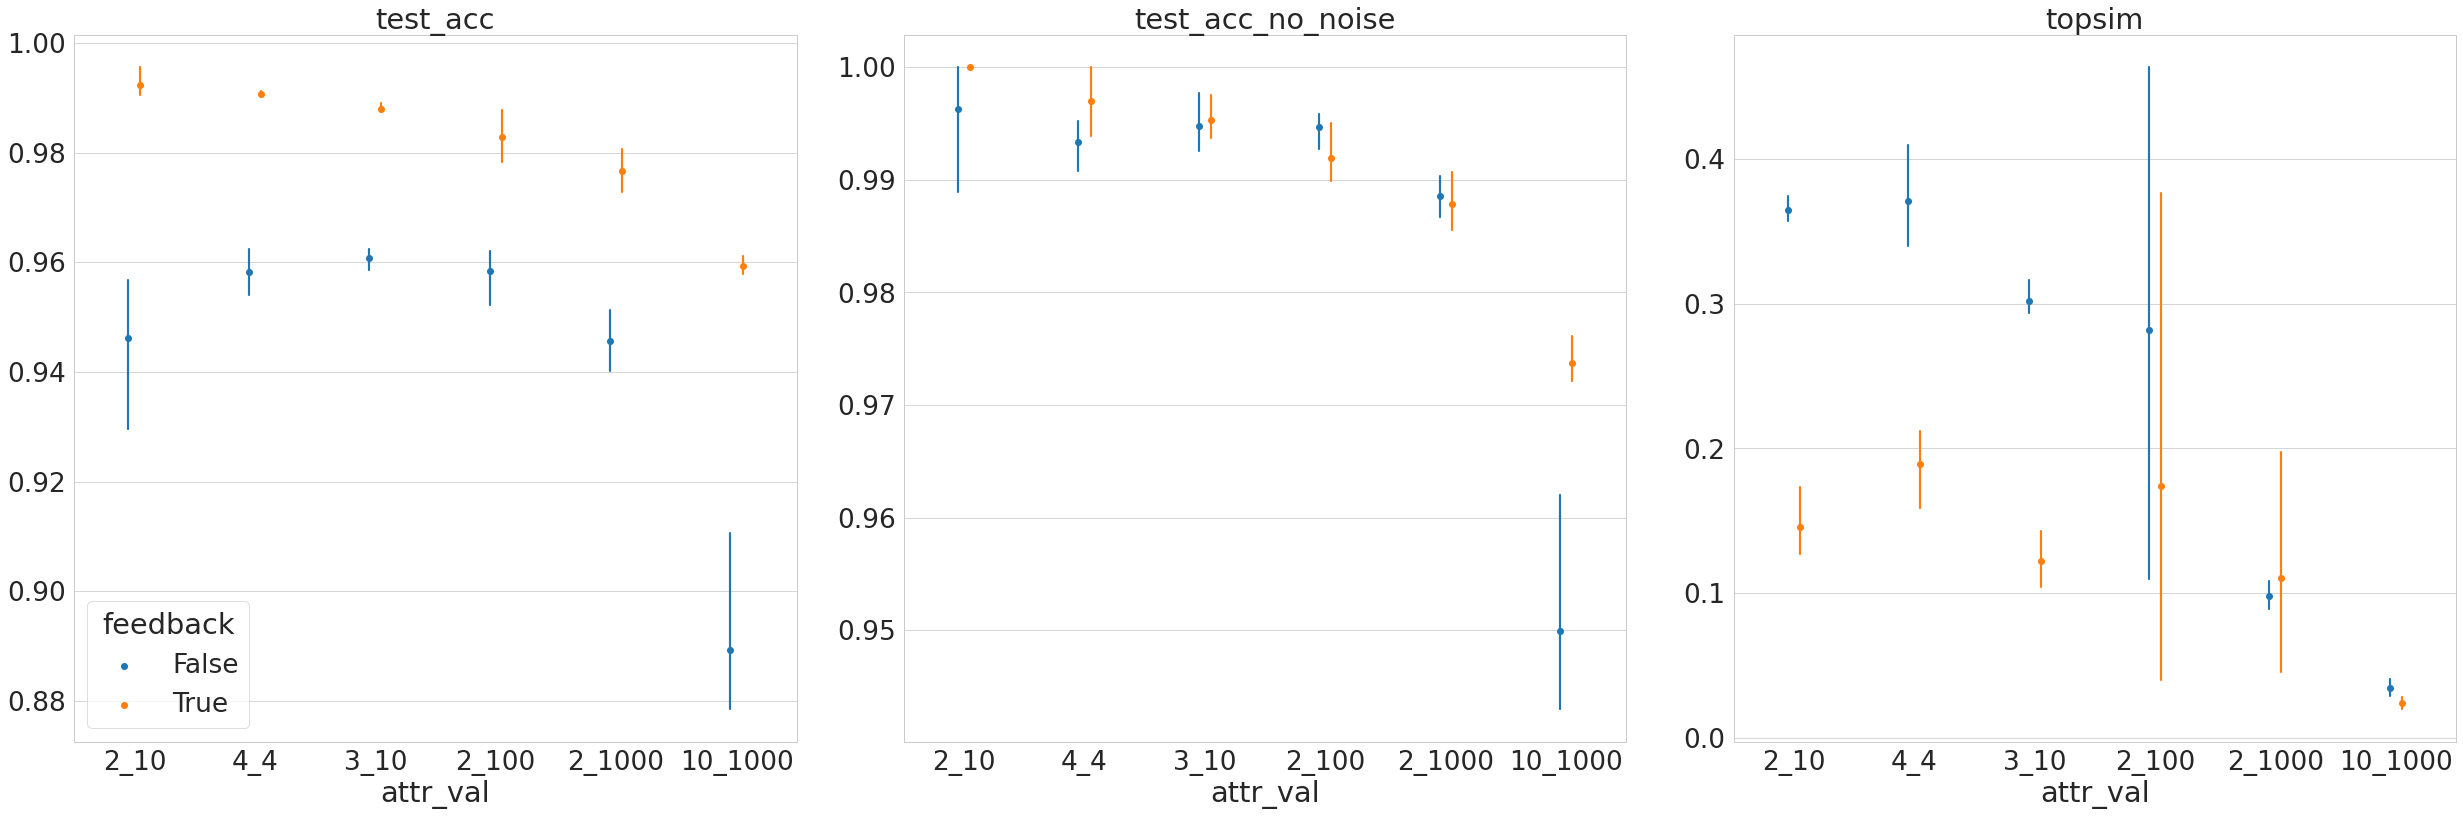

In [10]:
data["condition"] = data["noise"].map(lambda x: f"noise_{x}" if x > 0 else "baseline") + data["feedback"].map(lambda x: "_feedback" if x else "") + data["receiver_aux_loss"].map(lambda x: "_aux_loss" if x else "")

target_data = data.copy()

target_data = target_data[target_data.receiver_aux_loss == False]

NOISE_PERMUTATION=False
target_data = target_data[target_data.noise_permutation == NOISE_PERMUTATION]

NUM_AGENTS = 1
target_data = target_data[target_data.num_agents == NUM_AGENTS]

MAX_LEN = 10
target_data = target_data[target_data.max_len == MAX_LEN]

NOISE = 0.5
target_data = target_data[target_data.noise == NOISE]

VOCAB_SIZE = 2
target_data = target_data[target_data.vocab_size == VOCAB_SIZE]

VOCAB_SIZE_FEEDBACK = 2
target_data = target_data[(target_data.vocab_size_feedback == VOCAB_SIZE_FEEDBACK) | (target_data.feedback == False)]

LAYER_NORM = 1
target_data = target_data[target_data.layer_norm == LAYER_NORM]

DISCRIMINATION_NUM_OBJECTS = 2
target_data = target_data[target_data.discrimination_num_objects == DISCRIMINATION_NUM_OBJECTS]

# hue_order = None
# hue_order = ["baseline", "noise_0.1"]
hue_order = ["noise_0.5", "noise_0.5_feedback", "noise_0.5_feedback_aux_loss"]

# order = ["2_10", "3_5", "2_16", "4_4", "4_5", "3_10", "2_100"]
# order = ["2_100", "4_100", "10_100"]
order = ["2_10", "4_4", "3_10", "2_100", "2_1000", "10_1000"]

target_hparam = "attr_val"

num_runs_data = target_data.groupby(["attr_val", "condition"]).size().reset_index()


metrics = ["test_acc", "test_acc_no_noise", "topsim"]
# metrics = ["test_acc", "topsim", "topsim_sender_receiver", "posdis", "bosdis", "test_acc_no_noise", "train_acc_no_noise"]
_, axes = plt.subplots(1, len(metrics), figsize=(35, 12))

for value in order:
    for fb in [False, True]:
        d = target_data[(target_data[target_hparam] == value) & (target_data["feedback"] == fb)]
        if len(d) != 3:
            print(f"Unexpected number of datapoints: {len(d)}")
            print(value)
            print(fb)
            print(d)

for i, metric in enumerate(metrics):
    axis = axes[i]
    # g = sns.barplot(ax=axis, data=target_data, x=target_hparam, y=metric, order=order, hue="feedback", dodge=True)
    g = sns.pointplot(ax=axis, data=target_data, x=target_hparam, y=metric, order=order, hue="feedback", errorbar="se", linestyles="", dodge=0.1)

    if not i == 0:
        g.legend().remove()
    else:
        sns.move_legend(axis, "lower left")
    axis.set_title(metric)
    axis.set_ylabel("")
    # handles, labels = ax.get_legend_handles_labels()
    # num_conditions = int(len(handles)/2) if not hue_order else len(hue_order)

plt.tight_layout()
plt.savefig("plots/effect_of_attr_val.pdf", dpi=300)


noise: 0 | FB: False | ACC: 1.00+-0.00
topsim: 0.33+-0.10
topsim_sender_receiver: nan+-0.10
noise: 0 | FB: True | ACC: 1.00+-0.00
topsim: 0.34+-0.04
topsim_sender_receiver: 0.25+-0.04
noise: 0.1 | FB: False | ACC: 0.99+-0.00
topsim: 0.42+-0.08
topsim_sender_receiver: nan+-0.08
noise: 0.1 | FB: True | ACC: 0.99+-0.00
topsim: 0.39+-0.06
topsim_sender_receiver: 0.32+-0.06
noise: 0.3 | FB: False | ACC: 0.99+-0.00
topsim: 0.46+-0.05
topsim_sender_receiver: nan+-0.05
noise: 0.3 | FB: True | ACC: 0.99+-0.00
topsim: 0.22+-0.01
topsim_sender_receiver: 0.17+-0.01
noise: 0.5 | FB: False | ACC: 0.96+-0.00
topsim: 0.37+-0.04
topsim_sender_receiver: nan+-0.04
noise: 0.5 | FB: True | ACC: 0.99+-0.00
topsim: 0.19+-0.03
topsim_sender_receiver: nan+-0.03
noise: 0.7 | FB: False | ACC: 0.89+-0.00
topsim: 0.40+-0.04
topsim_sender_receiver: nan+-0.04
noise: 0.7 | FB: True | ACC: 0.96+-0.00
topsim: 0.19+-0.02
topsim_sender_receiver: 0.15+-0.02
noise: 0.9 | FB: False | ACC: 0.69+-0.01
topsim: 0.30+-0.05
topsi

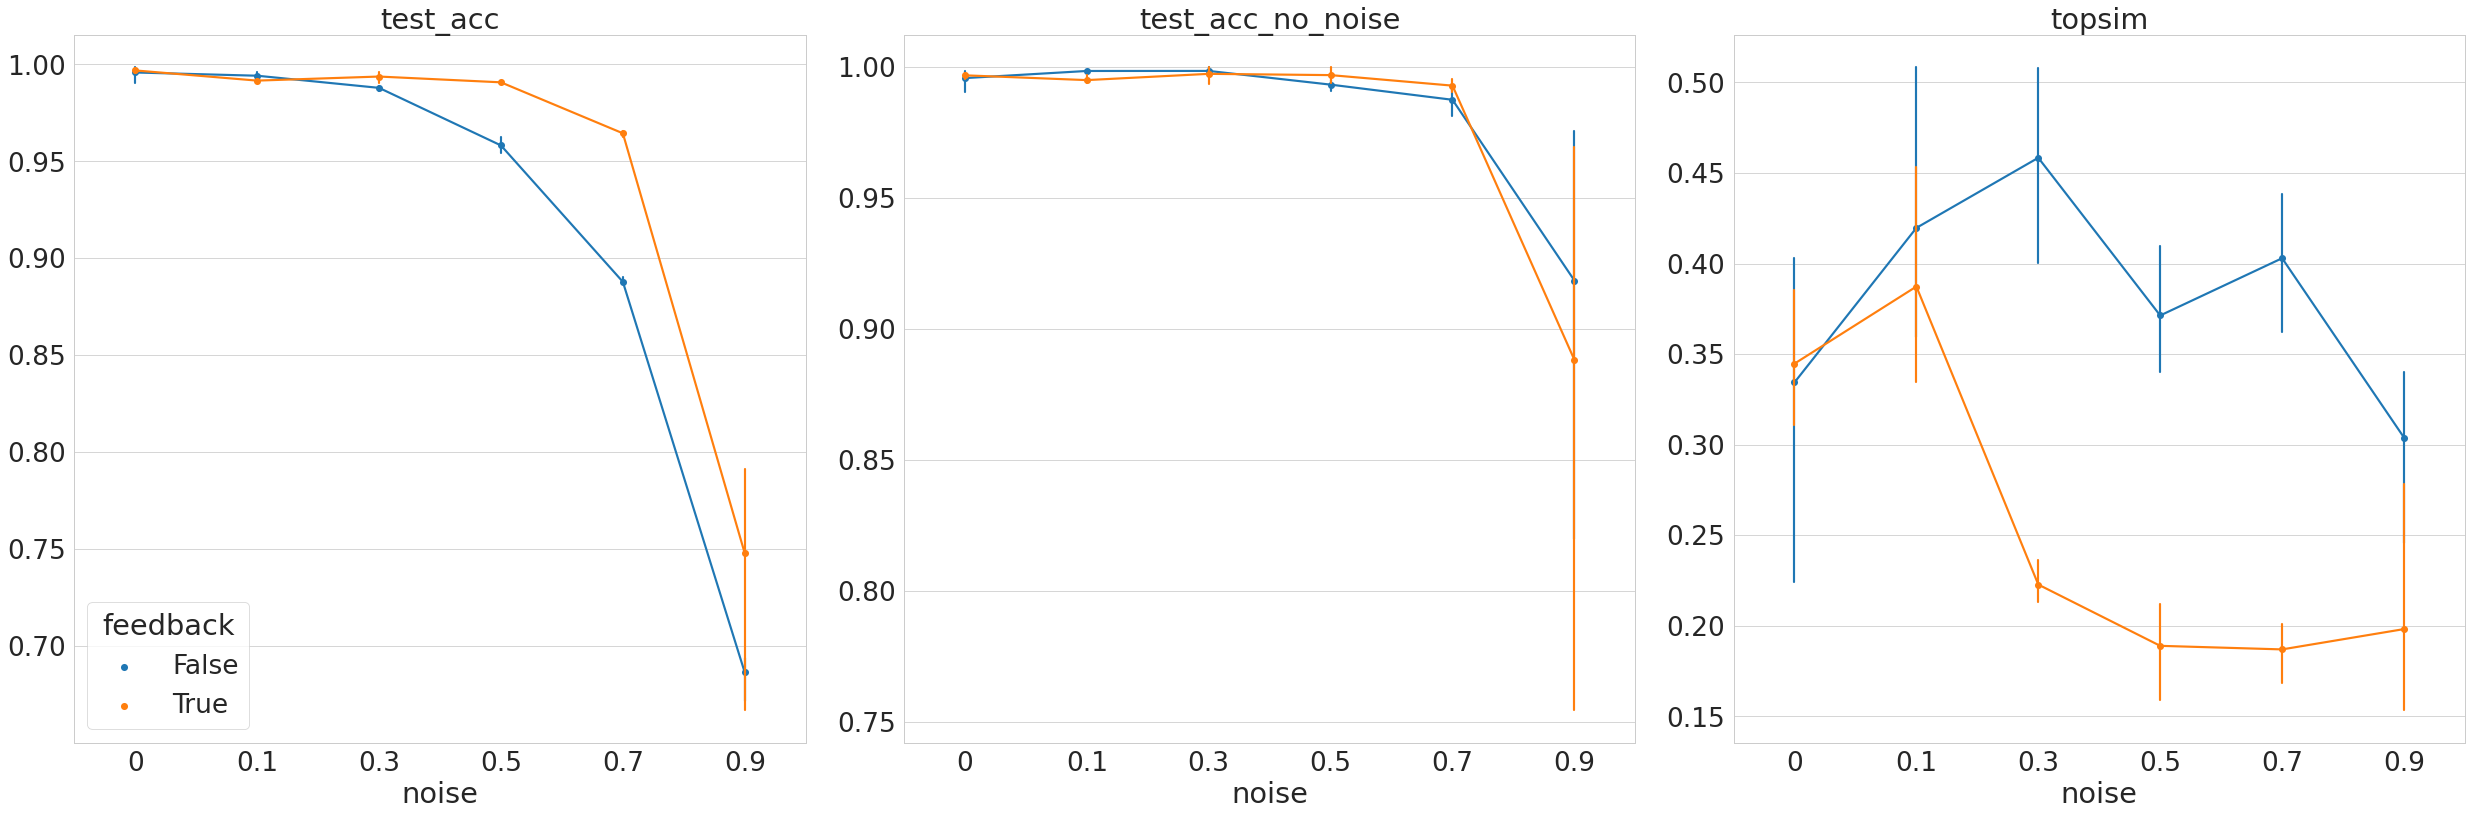

In [11]:
target_data = data.copy()

target_data = target_data[target_data.receiver_aux_loss == False]

NOISE_PERMUTATION=False
target_data = target_data[target_data.noise_permutation == NOISE_PERMUTATION]

NUM_AGENTS = 1
target_data = target_data[target_data.num_agents == NUM_AGENTS]

MAX_LEN = 10
target_data = target_data[target_data.max_len == MAX_LEN]

VOCAB_SIZE = 2
target_data = target_data[target_data.vocab_size == VOCAB_SIZE]

VOCAB_SIZE_FEEDBACK = 2
target_data = target_data[(target_data.vocab_size_feedback == VOCAB_SIZE_FEEDBACK) | (target_data.feedback == False)]

LAYER_NORM = 1
target_data = target_data[target_data.layer_norm == LAYER_NORM]

DISCRIMINATION_NUM_OBJECTS = 2
target_data = target_data[target_data.discrimination_num_objects == DISCRIMINATION_NUM_OBJECTS]

ATTR_VAL = "4_4"
# ATTR_VAL = "3_10"

target_data = target_data[(target_data["attr_val"] == ATTR_VAL)]

# print(target_data.dir_name.unique())
target_hparam = "noise"
order = [0, 0.1, 0.3, 0.5, 0.7, 0.9]


num_runs_data = target_data.groupby(["attr_val", "condition"]).size().reset_index()

metrics = ["test_acc", "test_acc_no_noise", "topsim"]
# metrics = ["test_acc", "topsim", "topsim_sender_receiver", "posdis", "bosdis", "test_acc_no_noise", "train_acc_no_noise"]
_, axes = plt.subplots(1, len(metrics), figsize=(35, 12))

hue_variable = "feedback"
for value in order:
    for fb in [False, True]:
        d = target_data[(target_data[target_hparam] == value) & (target_data[hue_variable] == fb)]
        if len(d) != 3:
            print(f"Unexpected number of datapoints: {len(d)}")
            print(value)
            print("fb: ", fb)
        else:
            print(f"noise: {value} | FB: {fb} | ACC: {d['test_acc'].mean():.2f}+-{d['test_acc'].std():.2f}")
            print(f"topsim: {d['topsim'].mean():.2f}+-{d['topsim'].std():.2f}")
            print(f"topsim_sender_receiver: {d['topsim_sender_receiver'].mean():.2f}+-{d['topsim'].std():.2f}")

    # print(d.dir_name)


for i, metric in enumerate(metrics):
    axis = axes[i]
    # g = sns.barplot(ax=axis, data=target_data, x=target_hparam, y=metric, order=order, hue=hue_variable, dodge=True)
    g = sns.pointplot(ax=axis, data=target_data, x=target_hparam, y=metric, order=order, hue=hue_variable, errorbar=('ci', 95))

    if not i == 0:
        g.legend().remove()
    else:
        sns.move_legend(axis, "lower left")
    axis.set_title(metric)
    axis.set_ylabel("")

plt.tight_layout()
plt.savefig("plots/effect_of_noise.pdf", dpi=300)

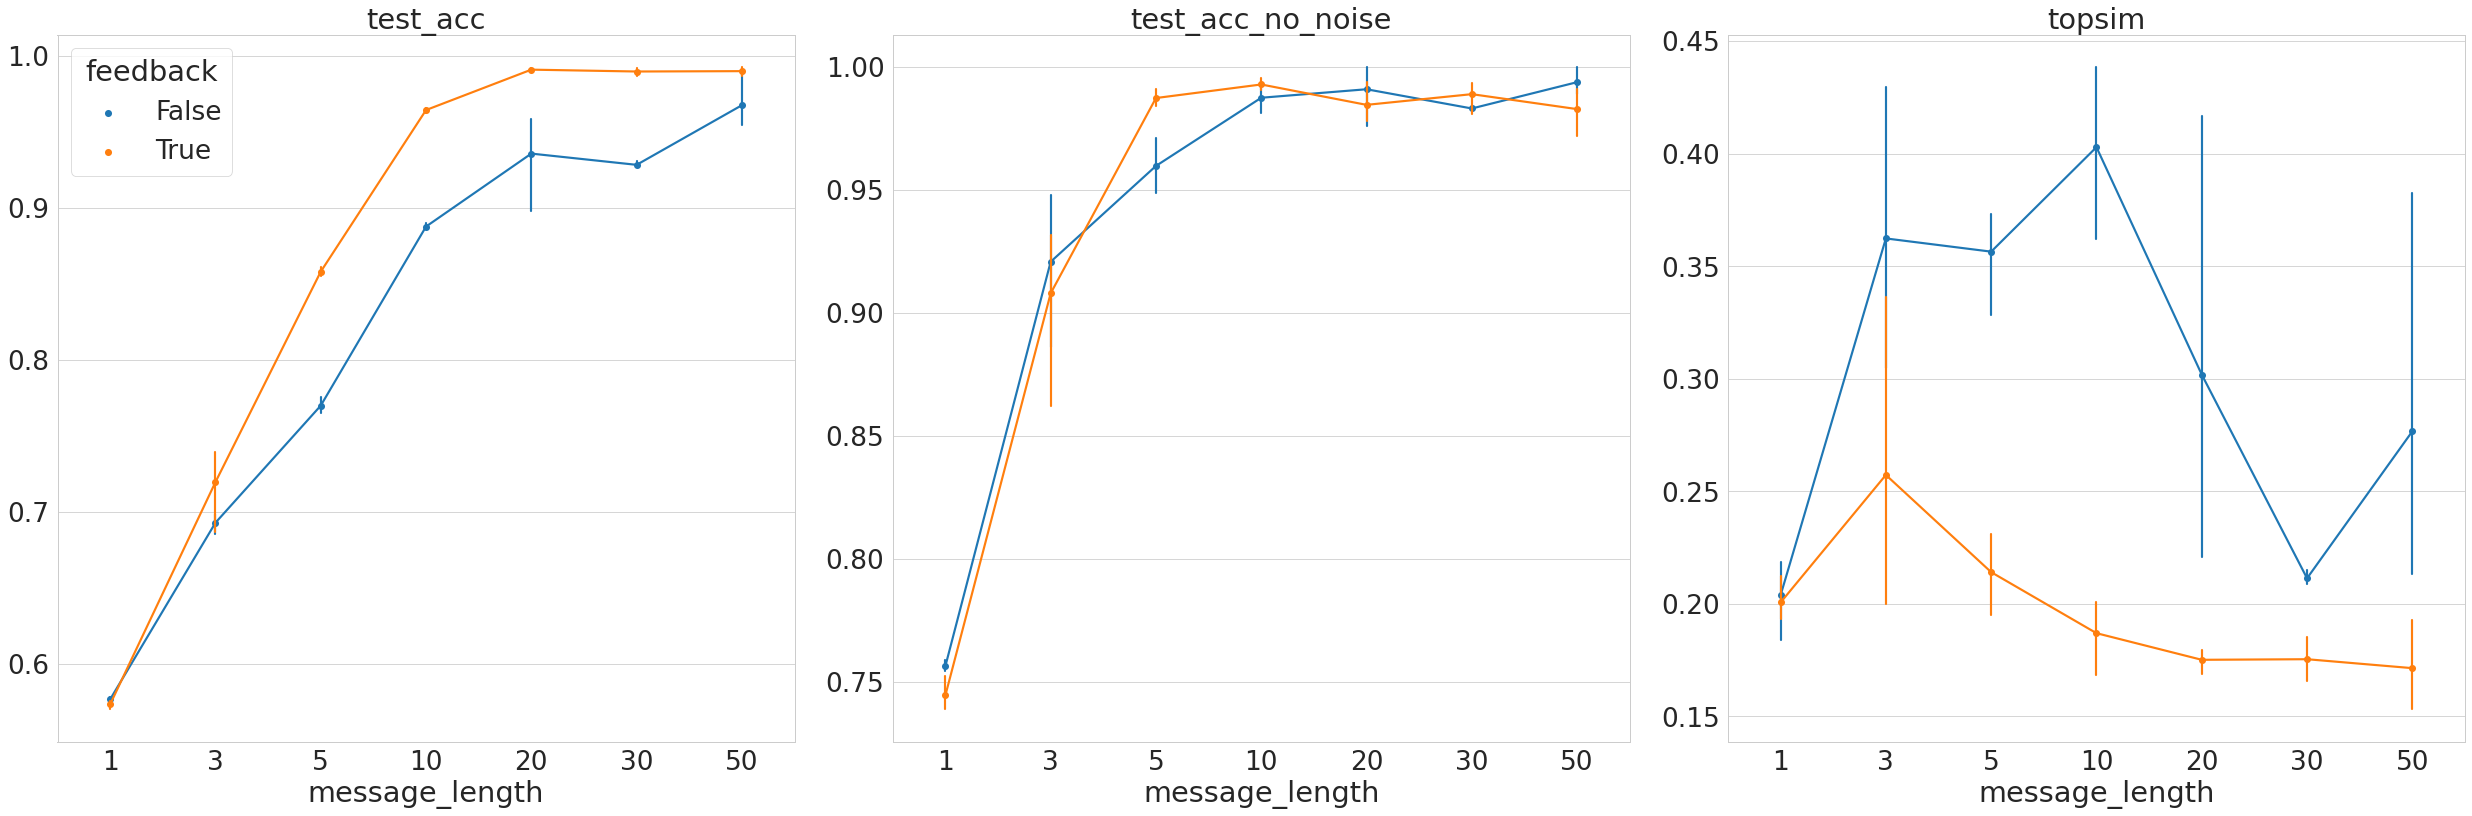

In [12]:
target_data = data.copy()

target_data = target_data[target_data.receiver_aux_loss == False]

NOISE_PERMUTATION=False
target_data = target_data[target_data.noise_permutation == NOISE_PERMUTATION]

NUM_AGENTS = 1
target_data = target_data[target_data.num_agents == NUM_AGENTS]

NOISE = 0.7
target_data = target_data[target_data.noise == NOISE]

VOCAB_SIZE = 2
target_data = target_data[target_data.vocab_size == VOCAB_SIZE]

VOCAB_SIZE_FEEDBACK = 2
target_data = target_data[(target_data.vocab_size_feedback == VOCAB_SIZE_FEEDBACK) | (target_data.feedback == False)]

LAYER_NORM = 1
target_data = target_data[target_data.layer_norm == LAYER_NORM]

DISCRIMINATION_NUM_OBJECTS = 2
target_data = target_data[target_data.discrimination_num_objects == DISCRIMINATION_NUM_OBJECTS]

ATTR_VAL = "4_4"

target_data = target_data[(target_data["attr_val"] == ATTR_VAL)]

# target_hparam = "attr_val"
# order = ["2_10", "4_4", "2_100", "2_1000"]
target_hparam = "max_len"
order = [1, 3, 5, 10, 20, 30, 50]


num_runs_data = target_data.groupby(["attr_val", "condition"]).size().reset_index()

metrics = ["test_acc", "test_acc_no_noise", "topsim"]
# metrics = ["test_acc", "topsim", "topsim_sender_receiver", "posdis", "bosdis", "test_acc_no_noise", "train_acc_no_noise"]
_, axes = plt.subplots(1, len(metrics), figsize=(35, 12))

hue_variable = "feedback"
for value in order:
    for fb in [False, True]:
        d = target_data[(target_data[target_hparam] == value) & (target_data[hue_variable] == fb)]
        if len(d) != 3:
            print(f"Unexpected number of datapoints: {len(d)}")
            print(value)
            print(fb)
            
for i, metric in enumerate(metrics):
    axis = axes[i]
    # g = sns.barplot(ax=axis, data=target_data, x=target_hparam, y=metric, order=order, hue="feedback", dodge=True)
    g = sns.pointplot(ax=axis, data=target_data, x=target_hparam, y=metric, order=order, hue=hue_variable, errorbar=('ci', 95))

    if not i == 0:
        g.legend().remove()
    else:
        sns.move_legend(axis, "upper left")
    axis.set_title(metric)
    axis.set_ylabel("")
    axis.set_xlabel("message_length")


plt.tight_layout()
plt.savefig("plots/effect_of_message_length.pdf", dpi=300)

noise: 0 | FB: False | ACC: 0.9937300086021423
noise: 0 | FB: True | ACC: 0.9932233492533366
noise: 0.1 | FB: False | ACC: 0.9759699900945028
noise: 0.1 | FB: True | ACC: 0.984196662902832
noise: 0.3 | FB: False | ACC: 0.9269733230272929
noise: 0.3 | FB: True | ACC: 0.9412800073623657
noise: 0.5 | FB: False | ACC: 0.8241166671117147
noise: 0.5 | FB: True | ACC: 0.857586661974589
noise: 0.7 | FB: False | ACC: 0.6981199979782104
noise: 0.7 | FB: True | ACC: 0.7060966690381368
noise: 0.9 | FB: False | ACC: 0.5621566573778788
noise: 0.9 | FB: True | ACC: 0.5575199921925863


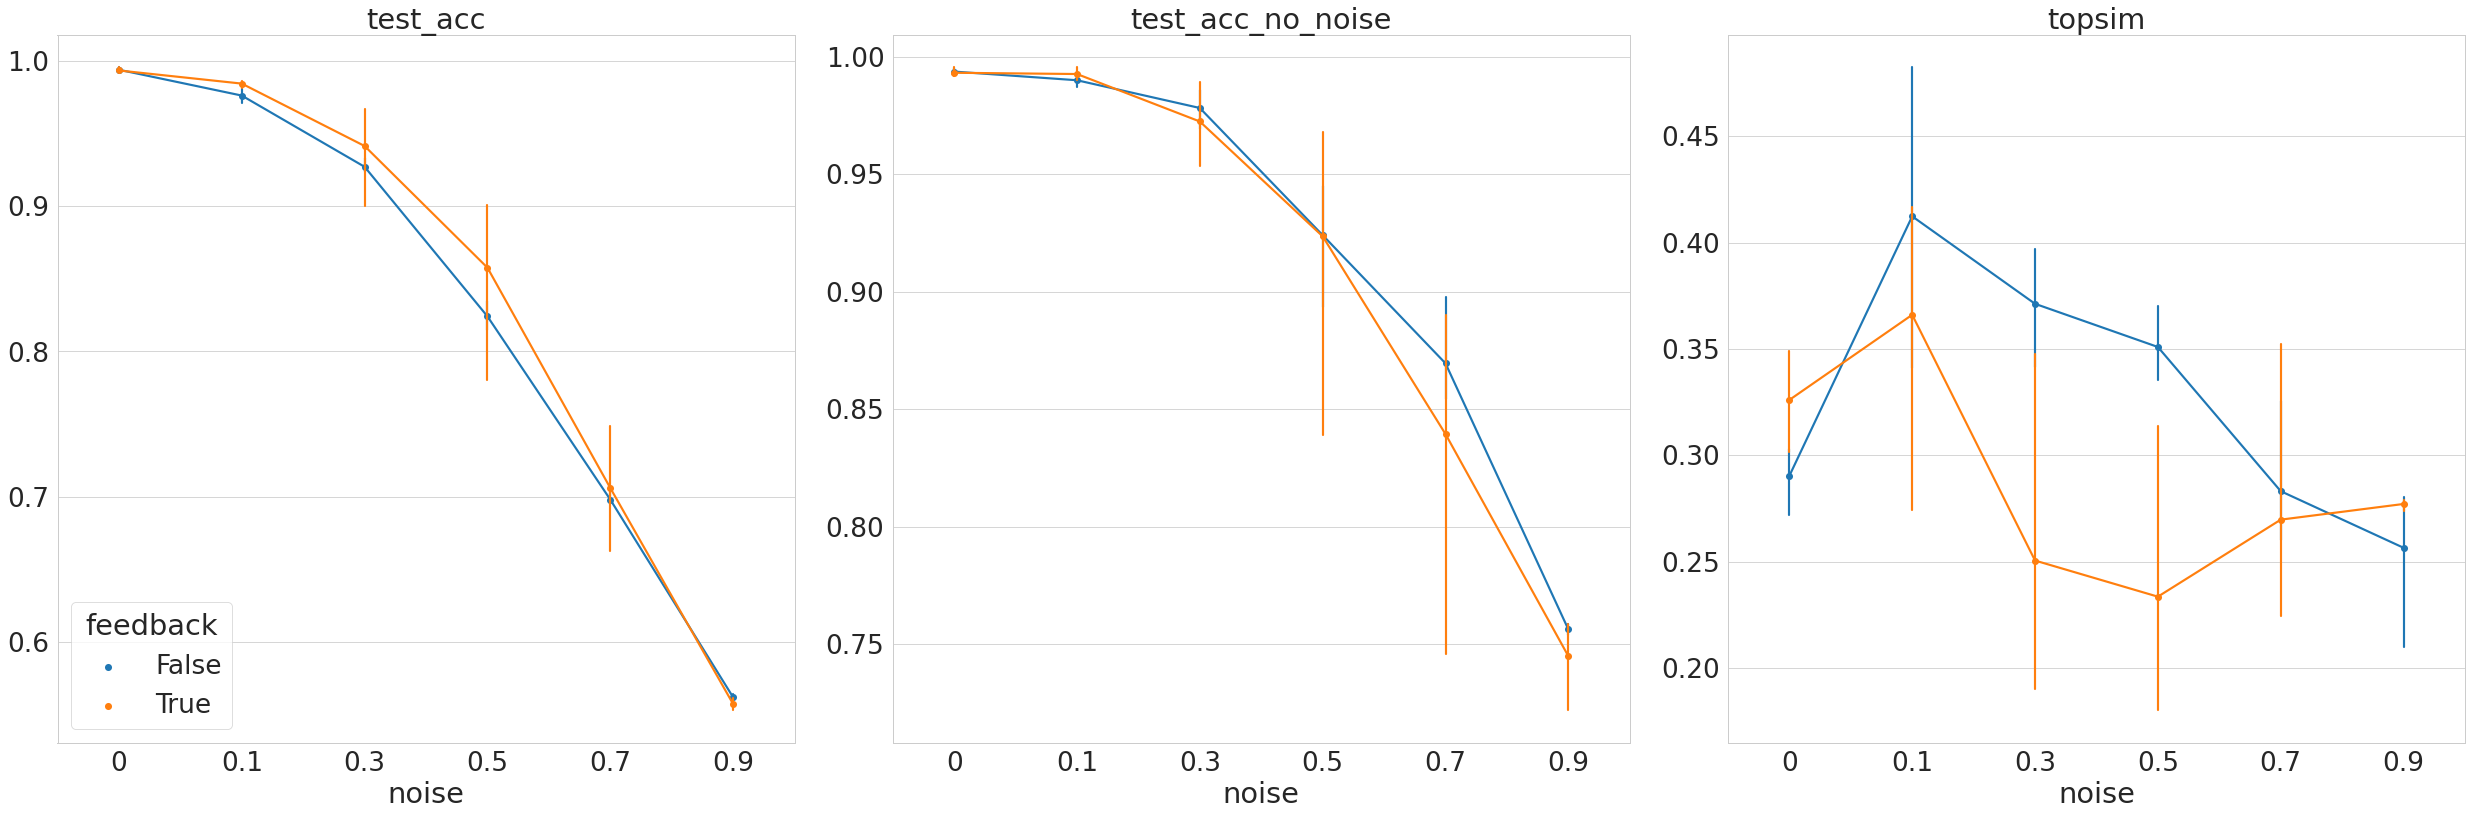

In [13]:
target_data = data.copy()

target_data = target_data[target_data.receiver_aux_loss == False]

NOISE_PERMUTATION=True
target_data = target_data[target_data.noise_permutation == NOISE_PERMUTATION]

NUM_AGENTS = 1
target_data = target_data[target_data.num_agents == NUM_AGENTS]

MAX_LEN = 10
target_data = target_data[target_data.max_len == MAX_LEN]

VOCAB_SIZE = 2
target_data = target_data[target_data.vocab_size == VOCAB_SIZE]

VOCAB_SIZE_FEEDBACK = 2
target_data = target_data[(target_data.vocab_size_feedback == VOCAB_SIZE_FEEDBACK) | (target_data.feedback == False)]

LAYER_NORM = 1
target_data = target_data[target_data.layer_norm == LAYER_NORM]

DISCRIMINATION_NUM_OBJECTS = 2
target_data = target_data[target_data.discrimination_num_objects == DISCRIMINATION_NUM_OBJECTS]

ATTR_VAL = "4_4"
# ATTR_VAL = "3_10"

target_data = target_data[(target_data["attr_val"] == ATTR_VAL)]

# print(target_data.dir_name.unique())
target_hparam = "noise"
order = [0, 0.1, 0.3, 0.5, 0.7, 0.9]


num_runs_data = target_data.groupby(["attr_val", "condition"]).size().reset_index()

metrics = ["test_acc", "test_acc_no_noise", "topsim"]
# metrics = ["test_acc", "topsim", "topsim_sender_receiver", "posdis", "bosdis", "test_acc_no_noise", "train_acc_no_noise"]
_, axes = plt.subplots(1, len(metrics), figsize=(35, 12))

hue_variable = "feedback"
for value in order:
    for fb in [False, True]:
        d = target_data[(target_data[target_hparam] == value) & (target_data[hue_variable] == fb)]
        if len(d) != 3:
            print(f"Unexpected number of datapoints: {len(d)}")
            print(value)
            print("fb: ", fb)
        else:
            print(f"noise: {value} | FB: {fb} | ACC: {d['test_acc'].mean()}")


for i, metric in enumerate(metrics):
    axis = axes[i]
    # g = sns.barplot(ax=axis, data=target_data, x=target_hparam, y=metric, order=order, hue=hue_variable, dodge=True)
    g = sns.pointplot(ax=axis, data=target_data, x=target_hparam, y=metric, order=order, hue=hue_variable, errorbar=('ci', 95))

    if not i == 0:
        g.legend().remove()
    else:
        sns.move_legend(axis, "lower left")
    axis.set_title(metric)
    axis.set_ylabel("")

plt.tight_layout()
plt.savefig("plots/effect_of_noise_alternative.pdf", dpi=300)

## Vocab size FB 10

noise: 0 | FB: False | ACC: 0.9958233038584391+-0.004593778083726366
noise: 0 | FB: True | Unexpected number of datapoints: 0
noise: 0 | FB: True | ACC: nan
noise: 0.1 | FB: False | ACC: 0.994159976641337+-0.002181648640010009
noise: 0.1 | FB: True | Unexpected number of datapoints: 0
noise: 0.1 | FB: True | ACC: nan
noise: 0.3 | FB: False | ACC: 0.987893303235372+-0.001284725231000031
noise: 0.3 | FB: True | Unexpected number of datapoints: 0
noise: 0.3 | FB: True | ACC: nan
noise: 0.5 | FB: False | ACC: 0.9581999778747559+-0.004135064341563353
noise: 0.5 | FB: True | ACC: 0.9822466572125753+-0.004995622589573567
noise: 0.7 | FB: False | ACC: 0.8878366351127625+-0.0019434264458268041
noise: 0.7 | FB: True | ACC: 0.9473333160082499+-0.006097472863121275
noise: 0.9 | FB: False | ACC: 0.6863033175468445+-0.012612231600475744
noise: 0.9 | FB: True | ACC: 0.7044033209482828+-0.06760743381239005


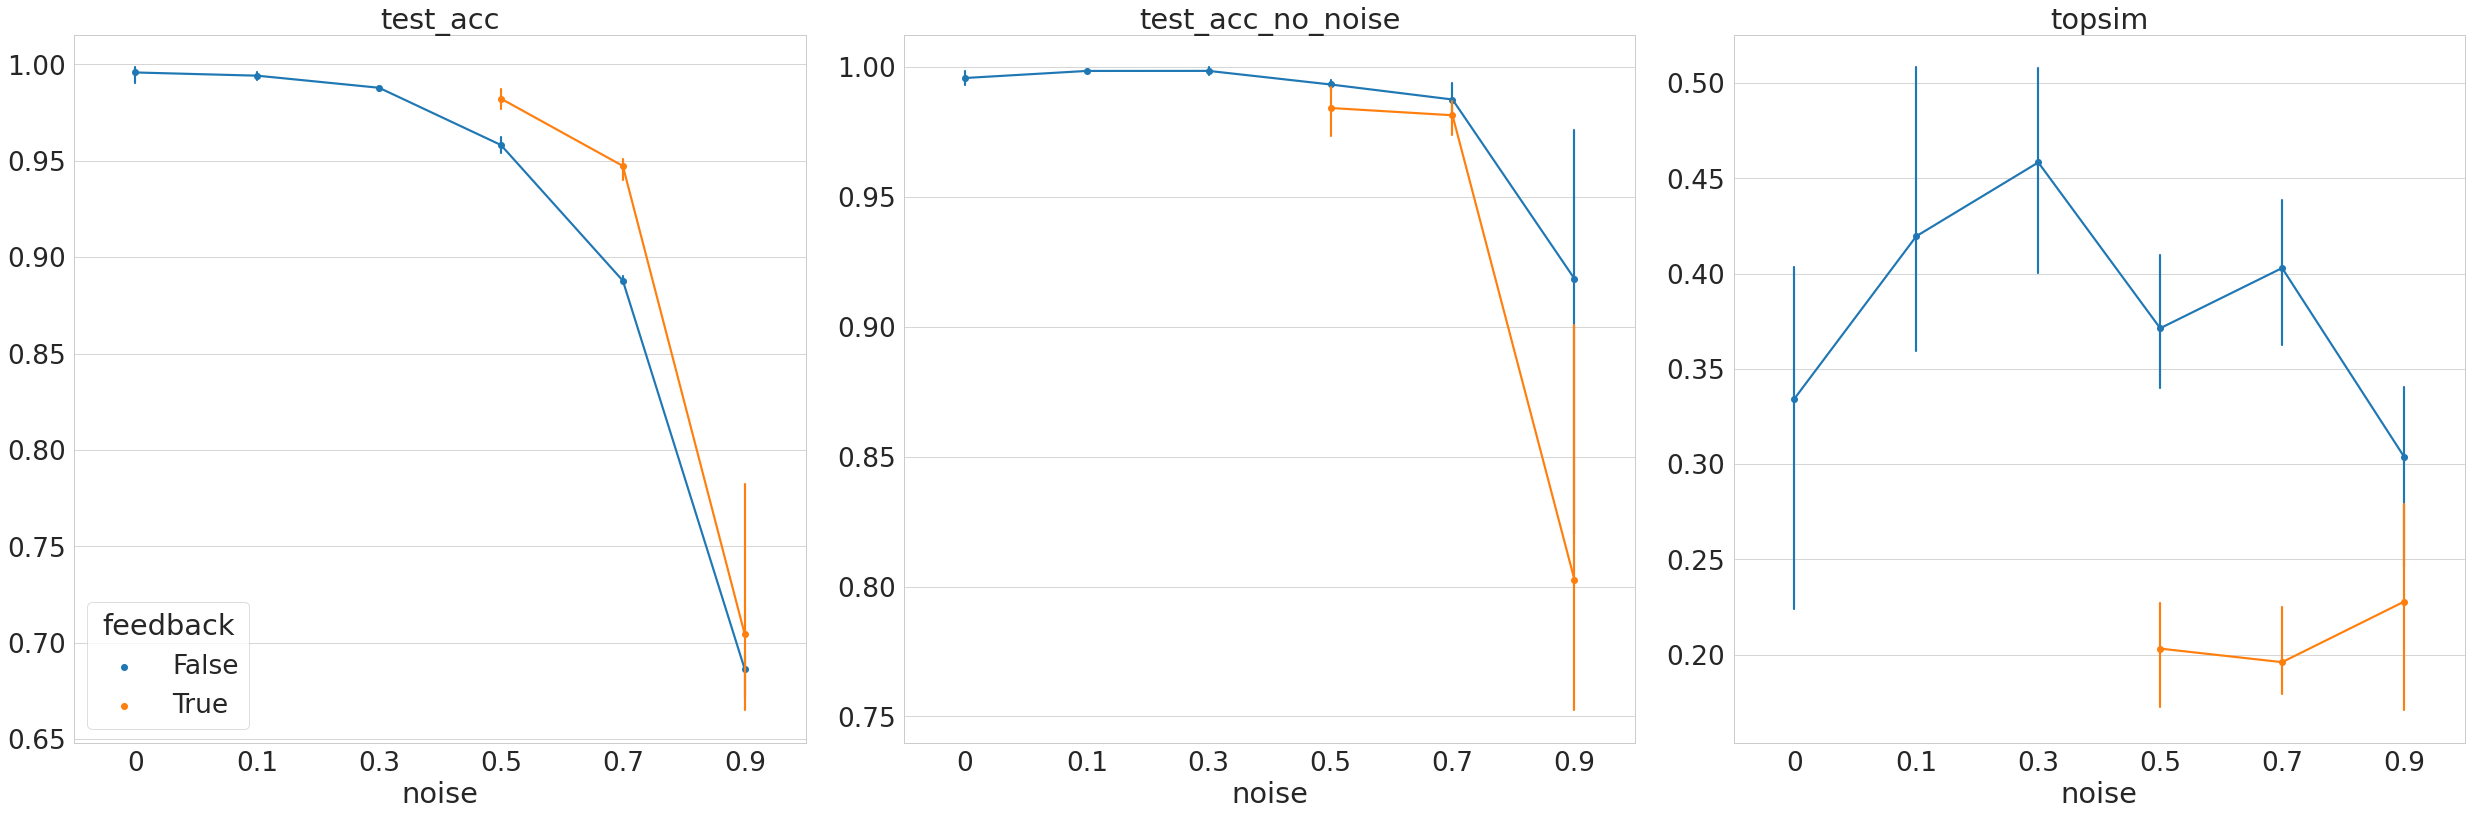

In [14]:
target_data = data.copy()

target_data = target_data[target_data.receiver_aux_loss == False]

NOISE_PERMUTATION=False
target_data = target_data[target_data.noise_permutation == NOISE_PERMUTATION]

NUM_AGENTS = 1
target_data = target_data[target_data.num_agents == NUM_AGENTS]

MAX_LEN = 10
target_data = target_data[target_data.max_len == MAX_LEN]

VOCAB_SIZE = 2
target_data = target_data[target_data.vocab_size == VOCAB_SIZE]

VOCAB_SIZE_FEEDBACK = 10
target_data = target_data[(target_data.vocab_size_feedback == VOCAB_SIZE_FEEDBACK) | (target_data.feedback == False)]

LAYER_NORM = 1
target_data = target_data[target_data.layer_norm == LAYER_NORM]

DISCRIMINATION_NUM_OBJECTS = 2
target_data = target_data[target_data.discrimination_num_objects == DISCRIMINATION_NUM_OBJECTS]

ATTR_VAL = "4_4"
# ATTR_VAL = "3_10"

target_data = target_data[(target_data["attr_val"] == ATTR_VAL)]

# print(target_data.dir_name.unique())
target_hparam = "noise"
order = [0, 0.1, 0.3, 0.5, 0.7, 0.9]


num_runs_data = target_data.groupby(["attr_val", "condition"]).size().reset_index()

metrics = ["test_acc", "test_acc_no_noise", "topsim"]
# metrics = ["test_acc", "topsim", "topsim_sender_receiver", "posdis", "bosdis", "test_acc_no_noise", "train_acc_no_noise"]
_, axes = plt.subplots(1, len(metrics), figsize=(35, 12))

hue_variable = "feedback"
for value in order:
    for fb in [False, True]:
        d = target_data[(target_data[target_hparam] == value) & (target_data[hue_variable] == fb)]
        if len(d) != 3:
            print(f"noise: {value} | FB: {fb} | Unexpected number of datapoints: {len(d)}")
            print(f"noise: {value} | FB: {fb} | ACC: {d['test_acc'].mean()}")
            # print(f": {len(d)}")
            # print(value)
            # print("fb: ", fb)
        else:
            print(f"noise: {value} | FB: {fb} | ACC: {d['test_acc'].mean()}+-{d['test_acc'].std()}")

for i, metric in enumerate(metrics):
    axis = axes[i]
    # g = sns.barplot(ax=axis, data=target_data, x=target_hparam, y=metric, order=order, hue=hue_variable, dodge=True)
    g = sns.pointplot(ax=axis, data=target_data, x=target_hparam, y=metric, order=order, hue=hue_variable, errorbar=('ci', 95))

    if not i == 0:
        g.legend().remove()
    else:
        sns.move_legend(axis, "lower left")
    axis.set_title(metric)
    axis.set_ylabel("")

plt.tight_layout()

## Receiver aux loss

noise: 0 | cond: feedback | ACC: 0.9968866507212321+-0.0014888269108598493
dir_name
version_42049    version_42049
version_42043    version_42043
version_42027    version_42027
Name: dir_name, dtype: object
noise: 0 | cond: no_feedback | ACC: 0.9958233038584391+-0.004593778083726366
dir_name
version_42046    version_42046
version_42034    version_42034
version_42023    version_42023
Name: dir_name, dtype: object
noise: 0 | cond: feedback_noise | ACC: 0.9927699963251749+-0.0011692355125083628
dir_name
version_43    version_43
version_49    version_49
version_37    version_37
Name: dir_name, dtype: object
noise: 0.1 | cond: feedback | ACC: 0.9916366338729858+-0.0006527206677326931
dir_name
version_39890    version_39890
version_39893    version_39893
version_36006    version_36006
Name: dir_name, dtype: object
noise: 0.1 | cond: no_feedback | ACC: 0.994159976641337+-0.002181648640010009
dir_name
version_39889    version_39889
version_39891    version_39891
version_36005    version_36005


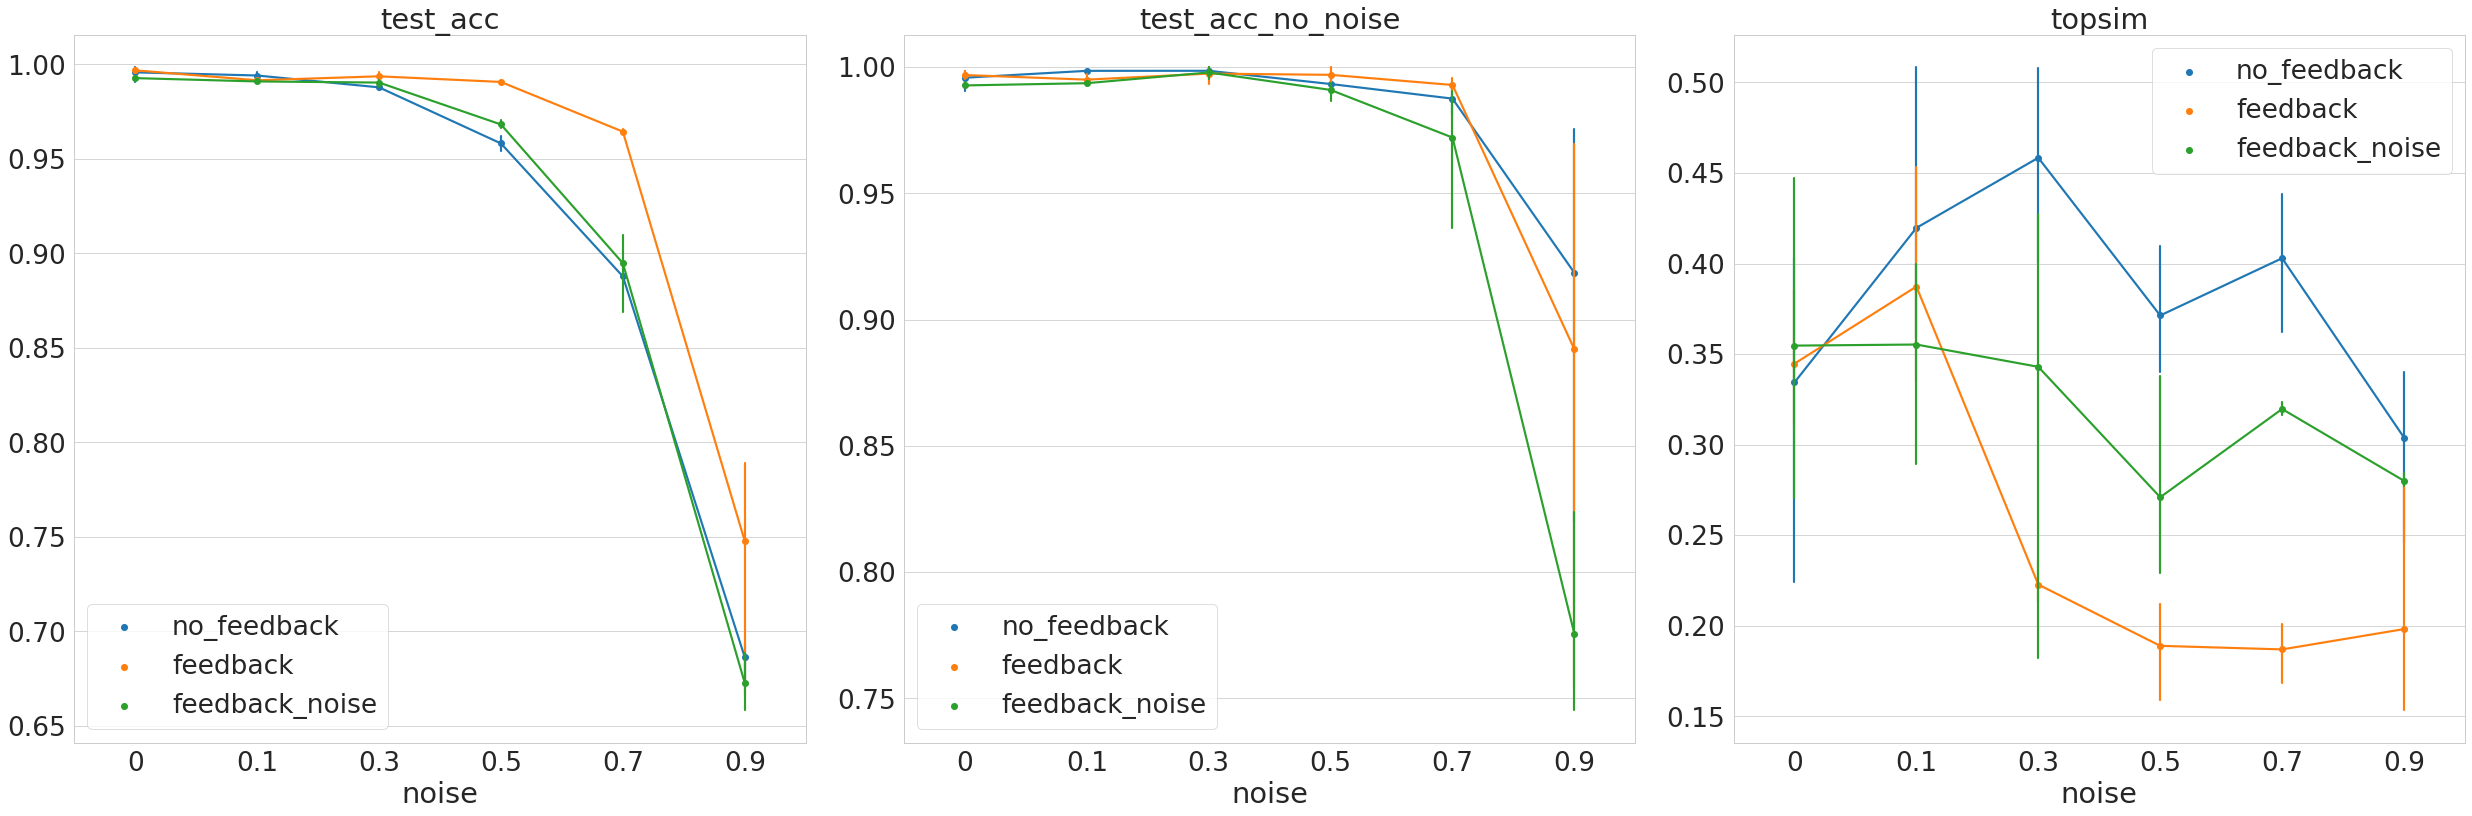

In [21]:
target_data = data.copy()

# target_data = target_data[target_data.receiver_aux_loss == False]

NOISE_PERMUTATION=False
target_data = target_data[target_data.noise_permutation == NOISE_PERMUTATION]

NUM_AGENTS = 1
target_data = target_data[target_data.num_agents == NUM_AGENTS]

MAX_LEN = 10
target_data = target_data[target_data.max_len == MAX_LEN]

VOCAB_SIZE = 2
target_data = target_data[target_data.vocab_size == VOCAB_SIZE]

VOCAB_SIZE_FEEDBACK = 2
target_data = target_data[(target_data.vocab_size_feedback == VOCAB_SIZE_FEEDBACK) | (target_data.feedback == False)]

LAYER_NORM = 1
target_data = target_data[target_data.layer_norm == LAYER_NORM]

DISCRIMINATION_NUM_OBJECTS = 2
target_data = target_data[target_data.discrimination_num_objects == DISCRIMINATION_NUM_OBJECTS]

ATTR_VAL = "4_4"
# ATTR_VAL = "3_10"

target_data = target_data[(target_data["attr_val"] == ATTR_VAL)]

# print(target_data.dir_name.unique())
target_hparam = "noise"
order = [0, 0.1, 0.3, 0.5, 0.7, 0.9]

target_data["hue_variable"] = data["feedback"].map(lambda x: "feedback" if x else "no_feedback") + data["receiver_aux_loss"].map(lambda x: "_noise" if x else "")

num_runs_data = target_data.groupby(["attr_val", "condition"]).size().reset_index()

metrics = ["test_acc", "test_acc_no_noise", "topsim"]
# metrics = ["test_acc", "topsim", "topsim_sender_receiver", "posdis", "bosdis", "test_acc_no_noise", "train_acc_no_noise"]
_, axes = plt.subplots(1, len(metrics), figsize=(35, 12))

hue_variable = "hue_variable"
for value in order:
    for cond in target_data.hue_variable.unique():
        d = target_data[(target_data[target_hparam] == value) & (target_data[hue_variable] == cond)]
        if len(d) != 3:
            print(f"Unexpected number of datapoints: {len(d)} noise {value} | cond {cond}")
        else:
            print(f"noise: {value} | cond: {cond} | ACC: {d['test_acc'].mean()}+-{d['test_acc'].std()}")
            print(d["dir_name"])

hue_order = ["no_feedback", "feedback", "feedback_noise"]
for i, metric in enumerate(metrics):
    axis = axes[i]
    # g = sns.barplot(ax=axis, data=target_data, x=target_hparam, y=metric, order=order, hue=hue_variable, dodge=True)
    g = sns.pointplot(ax=axis, data=target_data, x=target_hparam, y=metric, order=order, hue=hue_variable, hue_order=hue_order, errorbar=('ci', 95))

    if not i == 0:
        g.legend().remove()
    else:
        sns.move_legend(axis, "lower left")
    axis.set_title(metric)
    axis.set_ylabel("")
    axis.legend().set_title("")

plt.tight_layout()
plt.savefig("plots/effect_of_noise_aux_loss.pdf", dpi=300)

# Guesswhat

In [16]:
# target_data = data.copy()
# 
# target_data = target_data[target_data.guesswhat == True]
# 
# target_data = target_data[target_data.receiver_output_attention == False]
# target_data = target_data[target_data.receiver_object_attention == False]
# target_data = target_data[target_data.sender_attention == False]
# 
# target_data = target_data[(target_data.receiver_aux_loss == False)]
# 
# NOISE_PERMUTATION=False
# target_data = target_data[target_data.noise_permutation == NOISE_PERMUTATION]
# 
# NUM_AGENTS = 1
# target_data = target_data[target_data.num_agents == NUM_AGENTS]
# 
# MAX_LEN = 10
# target_data = target_data[target_data.max_len == MAX_LEN]
# 
# VOCAB_SIZE = 2
# target_data = target_data[target_data.vocab_size == VOCAB_SIZE]
# 
# VOCAB_SIZE_FEEDBACK = 2
# target_data = target_data[(target_data.vocab_size_feedback == VOCAB_SIZE_FEEDBACK) | (target_data.feedback == False)]
# 
# LAYER_NORM = 1
# target_data = target_data[target_data.layer_norm == LAYER_NORM]
# 
# DISCRIMINATION_NUM_OBJECTS = 10
# target_data = target_data[target_data.discrimination_num_objects == DISCRIMINATION_NUM_OBJECTS]
# 
# # target_hparam = "attr_val"
# # order = ["2_10", "4_4", "2_100", "2_1000"]
# target_hparam = "noise"
# order = [0, 0.1, 0.3, 0.5, 0.7, 0.9]
# 
# metrics = ["test_acc"] #test_acc_no_noise
# _, axes = plt.subplots(1, len(metrics)*2, figsize=(35, 12))
# 
# hue_variable = "feedback"
# for value in order:
#     for fb in [False, True]:
#         d = target_data[(target_data[target_hparam] == value) & (target_data[hue_variable] == fb)]
#         if len(d) != 3:
#             print(f"Unexpected number of datapoints: {len(d)}")
#             print(value)
#             print(fb)
#             
# for i, metric in enumerate(metrics):
#     axis = axes[i]
#     # g = sns.barplot(ax=axis, data=target_data, x=target_hparam, y=metric, order=order, hue="feedback", dodge=True)
#     g = sns.pointplot(ax=axis, data=target_data, x=target_hparam, y=metric, order=order, hue=hue_variable, errorbar=('ci', 95))
# 
#     if not i == 0:
#         g.legend().remove()
#     else:
#         sns.move_legend(axis, "lower left")
#     axis.set_title(metric)
#     axis.set_ylabel("")
#     # axis.set_ylim((0, 1))
# 
# 
# ###
# # SECOND HALF
# ###
# 
# target_data = data.copy()
# 
# target_data = target_data[target_data.guesswhat == True]
# 
# target_data = target_data[target_data.receiver_output_attention == False]
# target_data = target_data[target_data.receiver_object_attention == False]
# target_data = target_data[target_data.sender_attention == False]
# 
# target_data = target_data[target_data.receiver_aux_loss == False]
# 
# NOISE_PERMUTATION=False
# target_data = target_data[target_data.noise_permutation == NOISE_PERMUTATION]
# 
# NUM_AGENTS = 1
# target_data = target_data[target_data.num_agents == NUM_AGENTS]
# 
# NOISE = 0.5
# target_data = target_data[target_data.noise == NOISE]
# 
# VOCAB_SIZE = 2
# target_data = target_data[target_data.vocab_size == VOCAB_SIZE]
# 
# VOCAB_SIZE_FEEDBACK = 2
# target_data = target_data[(target_data.vocab_size_feedback == VOCAB_SIZE_FEEDBACK) | (target_data.feedback == False)]
# 
# LAYER_NORM = 1
# target_data = target_data[target_data.layer_norm == LAYER_NORM]
# 
# DISCRIMINATION_NUM_OBJECTS = 10
# target_data = target_data[target_data.discrimination_num_objects == DISCRIMINATION_NUM_OBJECTS]
# 
# # target_hparam = "attr_val"
# # order = ["2_10", "4_4", "2_100", "2_1000"]
# target_hparam = "max_len"
# order = [1, 5, 10, 20, 30, 50]
# 
# metrics = ["test_acc"] #test_acc_no_noise
# 
# hue_variable = "feedback"
# for value in order:
#     for fb in [False, True]:
#         d = target_data[(target_data[target_hparam] == value) & (target_data[hue_variable] == fb)]
#         if len(d) != 3:
#             print(f"Unexpected number of datapoints: {len(d)}")
#             print(value)
#             print(fb)
# 
# for i, metric in enumerate(metrics):
#     axis = axes[i+len(metrics)]
#     # g = sns.barplot(ax=axis, data=target_data, x=target_hparam, y=metric, order=order, hue="feedback", dodge=True)
#     g = sns.pointplot(ax=axis, data=target_data, x=target_hparam, y=metric, order=order, hue=hue_variable, errorbar=('ci', 95))
# 
#     if not i == 0:
#         g.legend().remove()
#     else:
#         sns.move_legend(axis, "upper left")
#     axis.set_title(metric)
#     axis.set_ylabel("")
#     axis.set_xlabel("message_length")
# 
# # axis.set_ylim((0, 1))
# 
# plt.tight_layout()
# plt.savefig("plots/guesswhat.pdf", dpi=300)

In [17]:
# target_data = data.copy()
# 
# target_data = target_data[target_data.guesswhat == True]
# 
# target_data = target_data[target_data.receiver_output_attention == False]
# target_data = target_data[target_data.receiver_object_attention == False]
# target_data = target_data[target_data.sender_attention == False]
# 
# target_data = target_data[(target_data.receiver_aux_loss == False)]
# 
# NOISE_PERMUTATION=False
# target_data = target_data[target_data.noise_permutation == NOISE_PERMUTATION]
# 
# NUM_AGENTS = 1
# target_data = target_data[target_data.num_agents == NUM_AGENTS]
# 
# MAX_LEN = 10
# target_data = target_data[target_data.max_len == MAX_LEN]
# 
# VOCAB_SIZE = 2
# target_data = target_data[target_data.vocab_size == VOCAB_SIZE]
# 
# VOCAB_SIZE_FEEDBACK = 2
# target_data = target_data[(target_data.vocab_size_feedback == VOCAB_SIZE_FEEDBACK) | (target_data.feedback == False)]
# 
# LAYER_NORM = 1
# target_data = target_data[target_data.layer_norm == LAYER_NORM]
# 
# DISCRIMINATION_NUM_OBJECTS = 10
# target_data = target_data[target_data.discrimination_num_objects == DISCRIMINATION_NUM_OBJECTS]
# 
# # target_hparam = "attr_val"
# # order = ["2_10", "4_4", "2_100", "2_1000"]
# target_hparam = "noise"
# order = [0, 0.1, 0.3, 0.5, 0.7, 0.9]
# 
# metrics = ["test_acc_no_noise"] #
# _, axes = plt.subplots(1, len(metrics)*2, figsize=(35, 12))
# 
# hue_variable = "feedback"
# for value in order:
#     for fb in [False, True]:
#         d = target_data[(target_data[target_hparam] == value) & (target_data[hue_variable] == fb)]
#         if len(d) != 3:
#             print(f"Unexpected number of datapoints: {len(d)}")
#             print(value)
#             print(fb)
# 
# for i, metric in enumerate(metrics):
#     axis = axes[i]
#     # g = sns.barplot(ax=axis, data=target_data, x=target_hparam, y=metric, order=order, hue="feedback", dodge=True)
#     g = sns.pointplot(ax=axis, data=target_data, x=target_hparam, y=metric, order=order, hue=hue_variable, errorbar=('ci', 95))
# 
#     if not i == 0:
#         g.legend().remove()
#     else:
#         sns.move_legend(axis, "lower left")
#     axis.set_title(metric)
#     axis.set_ylabel("")
#     # axis.set_ylim((0, 1))
# 
# 
# ###
# # SECOND HALF
# ###
# 
# target_data = data.copy()
# 
# target_data = target_data[target_data.guesswhat == True]
# 
# target_data = target_data[target_data.receiver_output_attention == False]
# target_data = target_data[target_data.receiver_object_attention == False]
# target_data = target_data[target_data.sender_attention == False]
# 
# target_data = target_data[target_data.receiver_aux_loss == False]
# 
# NOISE_PERMUTATION=False
# target_data = target_data[target_data.noise_permutation == NOISE_PERMUTATION]
# 
# NUM_AGENTS = 1
# target_data = target_data[target_data.num_agents == NUM_AGENTS]
# 
# NOISE = 0.5
# target_data = target_data[target_data.noise == NOISE]
# 
# VOCAB_SIZE = 2
# target_data = target_data[target_data.vocab_size == VOCAB_SIZE]
# 
# VOCAB_SIZE_FEEDBACK = 2
# target_data = target_data[(target_data.vocab_size_feedback == VOCAB_SIZE_FEEDBACK) | (target_data.feedback == False)]
# 
# LAYER_NORM = 1
# target_data = target_data[target_data.layer_norm == LAYER_NORM]
# 
# DISCRIMINATION_NUM_OBJECTS = 10
# target_data = target_data[target_data.discrimination_num_objects == DISCRIMINATION_NUM_OBJECTS]
# 
# # target_hparam = "attr_val"
# # order = ["2_10", "4_4", "2_100", "2_1000"]
# target_hparam = "max_len"
# order = [1, 5, 10, 20, 30, 50]
# 
# metrics = ["test_acc_no_noise"] #
# 
# hue_variable = "feedback"
# for value in order:
#     for fb in [False, True]:
#         d = target_data[(target_data[target_hparam] == value) & (target_data[hue_variable] == fb)]
#         if len(d) != 3:
#             print(f"Unexpected number of datapoints: {len(d)}")
#             print(value)
#             print(fb)
# 
# for i, metric in enumerate(metrics):
#     axis = axes[i+len(metrics)]
#     # g = sns.barplot(ax=axis, data=target_data, x=target_hparam, y=metric, order=order, hue="feedback", dodge=True)
#     g = sns.pointplot(ax=axis, data=target_data, x=target_hparam, y=metric, order=order, hue=hue_variable, errorbar=('ci', 95))
# 
#     if not i == 0:
#         g.legend().remove()
#     else:
#         sns.move_legend(axis, "upper left")
#     axis.set_title(metric)
#     axis.set_ylabel("")
#     axis.set_xlabel("message_length")
# 
# # axis.set_ylim((0, 1))
# 
# plt.tight_layout()
# plt.savefig("plots/guesswhat_no_noise.pdf", dpi=300)

In [18]:
# target_data = data.copy()
# 
# target_data = target_data[target_data.guesswhat == True]
# 
# target_data = target_data[target_data.receiver_output_attention == False]
# target_data = target_data[target_data.receiver_object_attention == False]
# target_data = target_data[target_data.sender_attention == False]
# 
# target_data = target_data[target_data.receiver_aux_loss == False]
# 
# 
# NOISE_PERMUTATION=False
# target_data = target_data[target_data.noise_permutation == NOISE_PERMUTATION]
# 
# NUM_AGENTS = 1
# target_data = target_data[target_data.num_agents == NUM_AGENTS]
# 
# NOISE = 0.5
# target_data = target_data[target_data.noise == NOISE]
# 
# VOCAB_SIZE = 2
# target_data = target_data[target_data.vocab_size == VOCAB_SIZE]
# 
# VOCAB_SIZE_FEEDBACK = 2
# target_data = target_data[(target_data.vocab_size_feedback == VOCAB_SIZE_FEEDBACK) | (target_data.feedback == False)]
# 
# LAYER_NORM = 1
# target_data = target_data[target_data.layer_norm == LAYER_NORM]
# 
# DISCRIMINATION_NUM_OBJECTS = 10
# target_data = target_data[target_data.discrimination_num_objects == DISCRIMINATION_NUM_OBJECTS]
# 
# # target_hparam = "attr_val"
# # order = ["2_10", "4_4", "2_100", "2_1000"]
# target_hparam = "max_len"
# order = [1, 5, 10, 20, 30, 50]
# 
# metrics = ["test_acc", "test_acc_no_noise", "train_acc"]
# # metrics = ["test_acc", "topsim", "topsim_sender_receiver", "posdis", "bosdis", "test_acc_no_noise", "train_acc_no_noise"]
# _, axes = plt.subplots(1, len(metrics), figsize=(35, 10))
# 
# hue_variable = "feedback"
# for value in order:
#     for fb in [False, True]:
#         d = target_data[(target_data[target_hparam] == value) & (target_data[hue_variable] == fb)]
#         if len(d) != 3:
#             print(f"Unexpected number of datapoints: {len(d)}")
#             print(value)
#             print(fb)
#             
# for i, metric in enumerate(metrics):
#     axis = axes[i]
#     # g = sns.barplot(ax=axis, data=target_data, x=target_hparam, y=metric, order=order, hue="feedback", dodge=True)
#     g = sns.pointplot(ax=axis, data=target_data, x=target_hparam, y=metric, order=order, hue=hue_variable, errorbar=('ci', 95), dodge=0.1)
# 
#     if not i == 0:
#         g.legend().remove()
#     else:
#         sns.move_legend(axis, "upper left")
#     axis.set_title(metric)
#     axis.set_ylabel("")
#     axis.set_xlabel("message_length")
# 
# # axis.set_ylim((0, 1))
# 
# plt.tight_layout()
# plt.savefig("plots/guesswhat_max_len.pdf", dpi=300)

In [19]:
# data = []
# 
# noise = [0.5324794832658659, 0.5335070968199509, 0.5335038136672091, 0.5339482142500649, 0.5332509060283926, 0.5333704351868614, 0.5327118284699583, 0.5300618360198712, 0.5303755071863462]
# for i, n in enumerate(noise):
#     data.append({"condition": "after noise token", "turn": i, "prob": n})
#     
# no_noise = [0.5354631303998393, 0.53442421325633, 0.53442849654834, 0.5339807338244494, 0.5346668254157241, 0.5345516733947143, 0.5352325882994804, 0.537851318115185, 0.5375381968005606]
# for i, n in enumerate(no_noise):
#     data.append({"condition": "after other token", "turn": i, "prob": n})
# 
# 
# 
# data = pd.DataFrame.from_records(data)
# 
# _, axes = plt.subplots(1, 2, figsize=(35, 12), sharey=True)
# # plt.figure(figsize=(10, 10))
# sns.pointplot(ax=axes[0], data=data, x="turn", y="prob", hue="condition")
# # plt.ylim((0, 1))
# 
# data_2 = []
# after_0 = [0.3780947411143967, 0.3950762783997905, 0.4079030503418036, 0.4179165733900455, 0.41563186322742424, 0.4177290918843091, 0.42253313184999913, 0.4264756773331581, 0.4233993503091271]
# for i, n in enumerate(after_0):
#     data_2.append({"condition": "after 0", "turn": i, "prob": n})
# 
# after_1 = [0.4266391045795913, 0.4277036238071697, 0.42208971246220744, 0.4135762664003001, 0.41550587560905705, 0.41043735842481266, 0.4081567511616348, 0.4106360314442512, 0.4131322223131404]
# for i, n in enumerate(after_1):
#     data_2.append({"condition": "after 1", "turn": i, "prob": n})
# 
# data_2 = pd.DataFrame.from_records(data_2)
# sns.pointplot(ax=axes[1], data=data_2, x="turn", y="prob", hue="condition")
# 
# # plt.ylim((0, 1))
# # sns.pointplot(x=turn, y=no_noise)
